In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

In [11]:
import pathlib
data_dir = pathlib.Path('Car_Recognition')

In [12]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

150


In [13]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 7 classes.
Using 120 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 150 files belonging to 7 classes.
Using 30 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['camion_carga', 'camioneta_familiar', 'deportivo', 'motocicleta', 'sedan', 'taxi', 'vehiculo_publico']


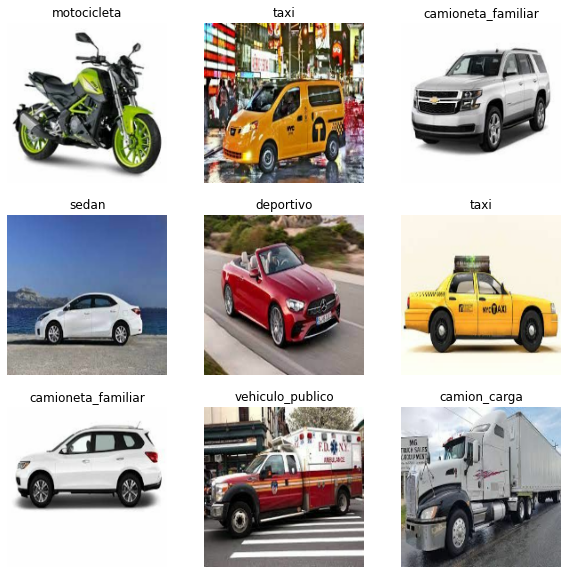

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
num_classes = 7

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=6
)

Epoch 1/6
4/4 [==============================] - 1s 255ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 2.1427 - val_accuracy: 0.5333
Epoch 2/6
4/4 [==============================] - 1s 253ms/step - loss: 8.7418e-04 - accuracy: 1.0000 - val_loss: 2.1733 - val_accuracy: 0.5333
Epoch 3/6
4/4 [==============================] - 1s 254ms/step - loss: 6.1607e-04 - accuracy: 1.0000 - val_loss: 2.1977 - val_accuracy: 0.5000
Epoch 4/6
4/4 [==============================] - 1s 251ms/step - loss: 5.0410e-04 - accuracy: 1.0000 - val_loss: 2.2133 - val_accuracy: 0.5000
Epoch 5/6
4/4 [==============================] - 1s 247ms/step - loss: 4.6417e-04 - accuracy: 1.0000 - val_loss: 2.2215 - val_accuracy: 0.5000
Epoch 6/6
4/4 [==============================] - 1s 251ms/step - loss: 4.3576e-04 - accuracy: 1.0000 - val_loss: 2.2182 - val_accuracy: 0.5000


In [25]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [28]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['camion_carga' 'camioneta_familiar' 'deportivo' 'motocicleta' 'sedan'
 'taxi' 'vehiculo_publico']


In [29]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [30]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [31]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [32]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [34]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


In [36]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

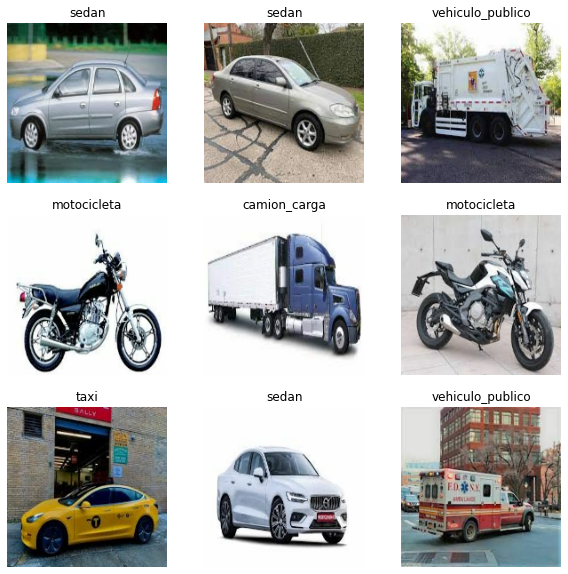

In [37]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

In [39]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5
)

Epoch 1/5
4/4 [==============================] - 1s 249ms/step - loss: 0.0561 - accuracy: 0.9833 - val_loss: 0.2992 - val_accuracy: 0.8667
Epoch 2/5
4/4 [==============================] - 1s 245ms/step - loss: 0.0363 - accuracy: 0.9917 - val_loss: 0.3410 - val_accuracy: 0.9000
Epoch 3/5
4/4 [==============================] - 1s 245ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.4109 - val_accuracy: 0.8667
Epoch 4/5
4/4 [==============================] - 1s 248ms/step - loss: 0.0124 - accuracy: 0.9917 - val_loss: 0.3201 - val_accuracy: 0.9000
Epoch 5/5
4/4 [==============================] - 1s 244ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.3125 - val_accuracy: 0.8667
